In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import cv2 as cv

In [ ]:
!pip install PyDrive # 安装一个包


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
# 以下两句代码在 Google Colab 才需要添加，其他平台忽略
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Colab Notebooks',
 'CreatedDataset',
 '.ipynb_checkpoints',
 'JPEGImages',
 'levle2_800.jpg',
 'levle2_801.jpg',
 'levle2_[1190 1174  829].jpg',
 'levle2_[1042 1026  818].jpg',
 'levle2_[966 996 826].jpg',
 'levle2_[1060 1080  817].jpg',
 'levle2_[1038 1036  810].jpg',
 'saved_model']

In [ ]:
import pathlib
data_dir="/content/drive/MyDrive/CreatedDataset"
data_dir = pathlib.Path(data_dir)

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow    
from skimage import io
from PIL import Image
import matplotlib.pylab as plt

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1931


In [ ]:
Level_0 = list(data_dir.glob('Level_0/*'))

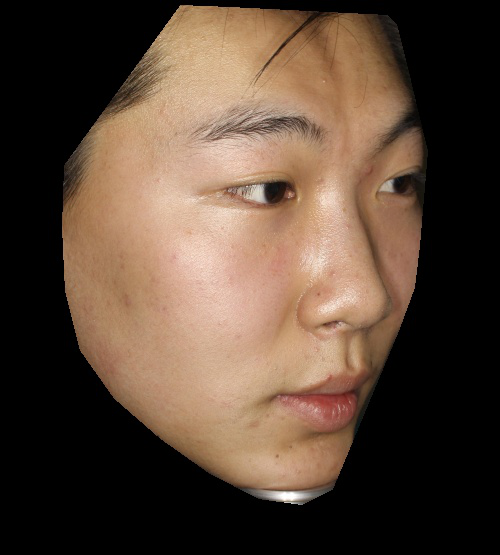

In [ ]:
PIL.Image.open(str(Level_0[1]))

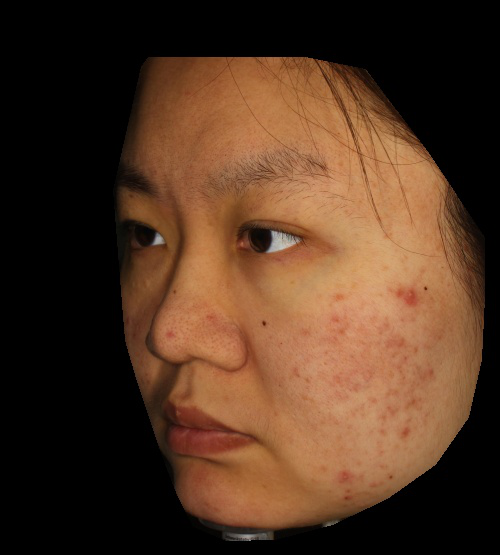

In [ ]:
Level_1 = list(data_dir.glob('Level_1/*'))
PIL.Image.open(str(Level_1[0]))

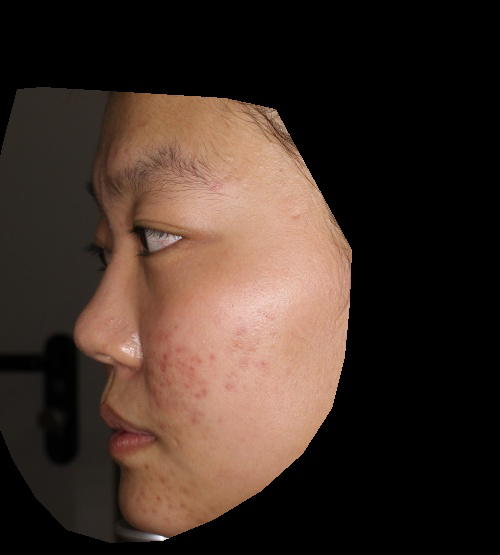

In [ ]:
PIL.Image.open(str(Level_1[1]))

In [ ]:
Level_2 = list(data_dir.glob('Level_2/*'))

In [ ]:
print(Level_2[0])

/content/drive/MyDrive/CreatedDataset/Level_2/levle2_150.jpg


In [ ]:
batch_size = 32
img_height = 500
img_width = 555

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1931 files belonging to 3 classes.
Using 1545 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1931 files belonging to 3 classes.
Using 386 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Level_0', 'Level_1', 'Level_2']


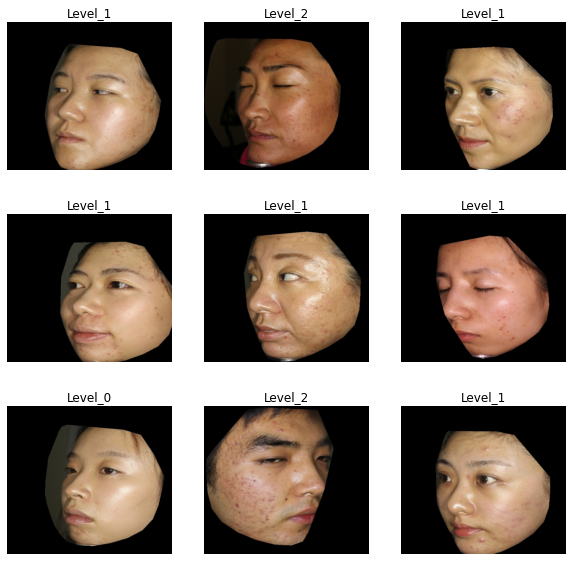

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 500, 555, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 500, 555, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 500, 555, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 250, 277, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 277, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 138, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 138, 64)      1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
49/49 [==============================] - 422s 9s/step - loss: 1.4763 - accuracy: 0.4816 - val_loss: 0.9390 - val_accuracy: 0.5026
Epoch 2/10
49/49 [==============================] - 375s 8s/step - loss: 0.9212 - accuracy: 0.5502 - val_loss: 0.8898 - val_accuracy: 0.5622
Epoch 3/10
49/49 [==============================] - 367s 8s/step - loss: 0.7789 - accuracy: 0.6589 - val_loss: 0.7938 - val_accuracy: 0.6321
Epoch 4/10
49/49 [==============================] - 365s 7s/step - loss: 0.5952 - accuracy: 0.7534 - val_loss: 0.6848 - val_accuracy: 0.7047
Epoch 5/10
49/49 [==============================] - 369s 8s/step - loss: 0.3848 - accuracy: 0.8583 - val_loss: 0.6700 - val_accuracy: 0.7720
Epoch 6/10
49/49 [==============================] - 370s 8s/step - loss: 0.1945 - accuracy: 0.9327 - val_loss: 0.6168 - val_accuracy: 0.8497
Epoch 7/10
49/49 [==============================] - 372s 8s/step - loss: 0.0919 - accuracy: 0.9754 - val_loss: 0.6796 - val_accuracy: 0.8549
Epoch 8/10
49

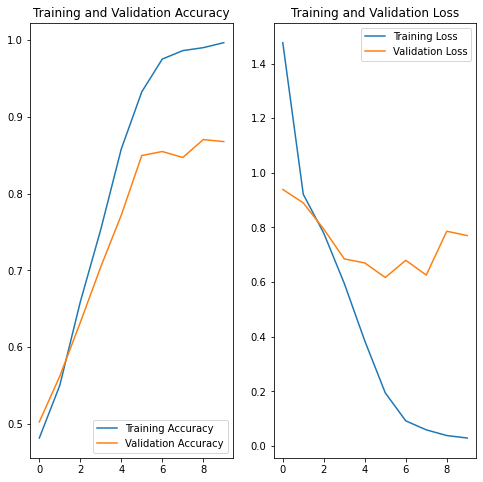

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
!pip install pyyaml h5py

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model_cnt')

INFO:tensorflow:Assets written to: saved_model/my_model_cnt/assets


In [ ]:
sunflower_url = "https://i02piccdn.sogoucdn.com/e95a05db76862f5e"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Level_1 with a 93.62 percent confidence.
